In [13]:
import glob

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
import regionmask

In [15]:
aus_shp = gp.read_file('/g/data/wp00/shared_code/shapefiles/australia/australia.shp')

In [11]:
def select_shapefile_regions(ds, shapes, lat_dim="lat", lon_dim="lon"):
    """Select region/s using a shapefile.
    Parameters
    ----------
    ds : xarray DataArray or Dataset
    shapes : geopandas GeoDataFrame
        Shapes/regions
    lat_dim: str, default 'lat'
        Name of the latitude dimension in ds
    lon_dim: str, default 'lon'
        Name of the longitude dimension in ds
    Returns
    -------
    ds : xarray DataArray or Dataset
    Notes
    -----
    Grid cells are selected if their centre point falls within the shape.
    
    regionmask requires the names of the horizontal spatial dimensions
    to be 'lat' and 'lon'
    """

    new_dim_names = {}
    if not lat_dim == "lat":
        new_dim_names[lat_dim] = "lat"
    if not lon_dim == "lon":
        new_dim_names[lon_dim] = "lon"
    if new_dim_names:
        ds = ds.rename_dims(new_dim_names)
    assert "lat" in ds.coords, "Latitude coordinate must be called lat"
    assert "lon" in ds.coords, "Longitude coordinate must be called lon"

    lons = ds["lon"].values
    lats = ds["lat"].values

    mask = regionmask.mask_geopandas(shapes, lons, lats)
    mask = mask.rename("region")

    mask = _nan_to_bool(mask)
    ds = ds.where(mask)
    ds = ds.dropna("lat", how="all")
    ds = ds.dropna("lon", how="all")

    return ds


def _nan_to_bool(mask):
    """Convert array of NaNs and floats to booleans.
    Parameters
    ----------
    mask : xarray DataArray
        Data array of NaN's and floats
    Returns
    -------
    mask : xarray DataArray
        Data array of True (where floats were) and False (where NaNs were) values
    """

    assert type(mask) == xr.core.dataarray.DataArray
    if mask.values.dtype != "bool":
        mask = xr.where(mask.notnull(), True, False)

    return mask

In [4]:
ds_pr = xr.open_dataset('/g/data/wp00/users/dbi599/test_space/alicia_precip_1981-2010-ARI20.nc')

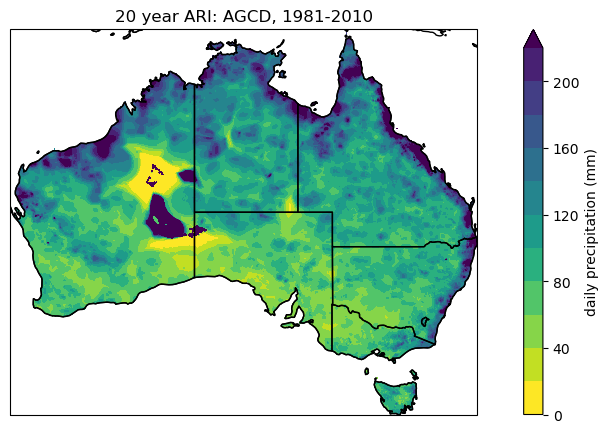

In [20]:
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_pr_aus = select_shapefile_regions(ds_pr, aus_shp)
ds_pr_aus['precip'].isel({'return_period': 0}).plot.contourf(
    ax=ax,
    levels=np.arange(0, 240, 20),
    extend='max',
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'daily precipitation (mm)'},
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
plt.title('20 year ARI: AGCD, 1981-2010')

plt.savefig(
    '/g/data/wp00/users/dbi599/test_space/precip_ARI_20yr_AGCD_1981-2010.png',
    bbox_inches='tight',
    dpi=300,
    facecolor='white',
)

In [18]:
ds_tmax = xr.open_dataset('/g/data/wp00/users/dbi599/test_space/alicia_tmax_1981-2010-ARI20.nc')

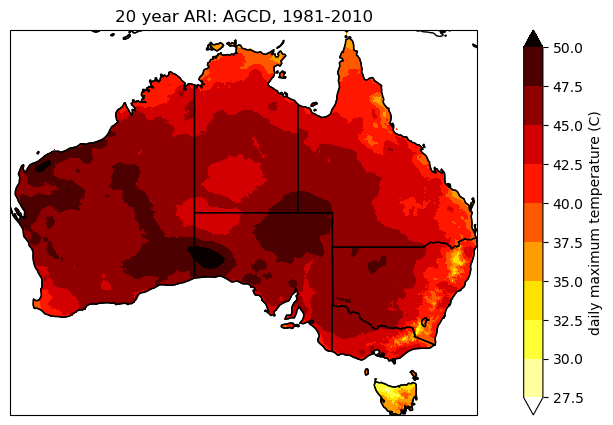

In [25]:
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_tmax_aus = select_shapefile_regions(ds_tmax, aus_shp)
ds_tmax_aus['tmax'].isel({'return_period': 0}).plot.contourf(
    ax=ax,
    levels=np.arange(27.5, 50.1, 2.5),
    extend='both',
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'daily maximum temperature (C)'},
    cmap='hot_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
plt.title('20 year ARI: AGCD, 1981-2010')

plt.savefig(
    '/g/data/wp00/users/dbi599/test_space/tmax_ARI_20yr_AGCD_1981-2010.png',
    bbox_inches='tight',
    dpi=300,
    facecolor='white',
)